In [10]:
#Khai báo các thư viện 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model # type: ignore

#Các lớp để xây dựng mô hình
from keras.models import Sequential #Đầu vào 
from keras.layers import LSTM #Học phụ thuộc
from keras.layers import Dropout# Tránh học tủ over fitting
from keras.layers import Dense #Đầu ra

#Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #Đo phần trăm sai số tuyệt đối trung bình 

import json
import time
import import_ipynb


In [11]:
import pandas as pd
from kafka import KafkaConsumer
import time
import io

# Thời gian chờ (giây)
timeout_duration = 10

# Tạo Kafka Consumer
consumer = KafkaConsumer(
    "sic_4",
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Danh sách để lưu trữ các tin nhắn
messages = []

# Thời gian bắt đầu
start_time = time.time()

# Vòng lặp để đọc tin nhắn
while True:
    # Lấy tin nhắn từ Kafka
    new_messages = consumer.poll(timeout_ms=1000)
    
    # Kiểm tra xem có tin nhắn mới không
    if new_messages:
        for topic_partition, messages_batch in new_messages.items():
            for message in messages_batch:
                messages.append(message.value.decode('utf-8'))
        # Đặt lại thời gian bắt đầu khi có tin nhắn mới
        start_time = time.time()
    else:
        # Kiểm tra xem có vượt quá thời gian chờ không
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout_duration:
            break

# Chuyển danh sách tin nhắn thành DataFrame
data = "\n".join(messages)
df = pd.read_csv(io.StringIO(data), header=None)

# Xóa dòng đầu tiên (tiêu đề cột không mong muốn)
df = df.iloc[1:].reset_index(drop=True)

# Xem số cột và tên cột hiện tại
print("Số cột hiện có:", len(df.columns))
#print(df.head())

# Xóa các dòng chứa tiêu đề không mong muốn
df = df[~df.iloc[:, 0].str.contains('Date', na=False)].reset_index(drop=True)

# Giữ lại chỉ những cột cần thiết và bỏ cột thừa
expected_columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.']
if len(df.columns) >= len(expected_columns):
    # Giữ lại các cột cần thiết
    df = df.iloc[:, :len(expected_columns)]
    df.columns = expected_columns

    # Đảm bảo các cột là kiểu dữ liệu string trước khi chuyển đổi
    df = df.astype(str)

    # Loại bỏ ký tự không hợp lệ như dấu phẩy
    df['Price'] = df['Price'].str.replace(',', '')
    df['Open'] = df['Open'].str.replace(',', '')
    df['High'] = df['High'].str.replace(',', '')
    df['Low'] = df['Low'].str.replace(',', '')
    df['Vol.'] = df['Vol.'].str.replace(',', '')

    # Chuyển đổi các cột giá từ chuỗi sang số, với kiểm tra lỗi
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

    # Chuyển đổi cột ngày tháng
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
    #print(df['Date'].head(20))  # Kiểm tra lại kết quả sau khi chuyển đổi

    # Xử lý giá trị NaN nếu cần
    df.fillna(method='ffill', inplace=True)  # Ví dụ: điền dữ liệu thiếu bằng cách forward fill

    # Hiển thị DataFrame sau khi tiền xử lý
    df=df[::-1]
    df = df.drop_duplicates(subset=['Date'])
    #Reset lại chỉ số sau khi xóa các giá trị trùng lặp!
    df = df.reset_index(drop=True)


    print(df)
else:
    print("Dữ liệu không đủ để xử lý")


Số cột hiện có: 7
           Date  Price   Open   High    Low  Vol.
0    2014-09-05   7854   7854   7854   7854   NaN
1    2014-09-09   7497   7497   7497   7497   NaN
2    2014-09-10   7140   7140   7140   7140   NaN
3    2014-09-11   6783   6783   6783   6783   NaN
4    2014-09-12   6426   6426   6426   6426   NaN
...         ...    ...    ...    ...    ...   ...
1219 2024-06-26  18800  18800  18800  18800   NaN
1220 2024-07-01  18700  18700  18700  18700   NaN
1221 2024-07-17  18800  18900  18900  18800   NaN
1222 2024-08-12  16500  16100  16500  16000   NaN
1223 2024-08-15  16100  16100  16100  16100   NaN

[1224 rows x 6 columns]


C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_7276\1899687751.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Ví dụ: điền dữ liệu thiếu bằng cách forward fill


In [12]:
df = df.drop(columns=['Vol.'])
m=len(df)
a= int((m*2)//3)
b=int(m-a)
print(df)


           Date  Price   Open   High    Low
0    2014-09-05   7854   7854   7854   7854
1    2014-09-09   7497   7497   7497   7497
2    2014-09-10   7140   7140   7140   7140
3    2014-09-11   6783   6783   6783   6783
4    2014-09-12   6426   6426   6426   6426
...         ...    ...    ...    ...    ...
1219 2024-06-26  18800  18800  18800  18800
1220 2024-07-01  18700  18700  18700  18700
1221 2024-07-17  18800  18900  18900  18800
1222 2024-08-12  16500  16100  16500  16000
1223 2024-08-15  16100  16100  16100  16100

[1224 rows x 5 columns]


In [13]:
# Sử dụng tất cả các cột cần dự đoán
df1 = pd.DataFrame(data=df, columns=['Date', 'Price', 'Open', 'High', 'Low'])
df1.index = df1.Date
df1.drop('Date', axis=1, inplace=True)
df1.head()


,Price,Open,High,Low
Date,,,,
2014-09-05,7854,7854,7854,7854
2014-09-09,7497,7497,7497,7497
2014-09-10,7140,7140,7140,7140
2014-09-11,6783,6783,6783,6783
2014-09-12,6426,6426,6426,6426


In [14]:
# Lấy dữ liệu và chuẩn hóa
data = df1.values
train_data = data[:a]  # Dữ liệu huấn luyện
test_data = data[a:]  # Dữ liệu kiểm tra

# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(train_data)
# Tạo dữ liệu x_train và y_train cho nhiều cột
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i-50:i])  # Lấy toàn bộ cột dữ liệu
    y_train.append(sc_train[i])

# Chuyển đổi thành numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)


In [15]:
# Xây dựng mô hình
model = Sequential()
model.add(LSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))  # Số lượng cột đầu ra bằng với số cột cần dự đoán
model.compile(loss='mean_absolute_error', optimizer='adam')

# Huấn luyện mô hình
save_model = "save_model_multi_output.hdf5"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/100

Epoch 1: loss improved from inf to 0.19441, saving model to save_model_multi_output.hdf5
16/16 - 10s - loss: 0.1944 - 10s/epoch - 621ms/step
Epoch 2/100

Epoch 2: loss improved from 0.19441 to 0.11630, saving model to save_model_multi_output.hdf5
16/16 - 2s - loss: 0.1163 - 2s/epoch - 111ms/step
Epoch 3/100

Epoch 3: loss improved from 0.11630 to 0.10659, saving model to save_model_multi_output.hdf5
16/16 - 2s - loss: 0.1066 - 2s/epoch - 120ms/step
Epoch 4/100

Epoch 4: loss improved from 0.10659 to 0.10593, saving model to save_model_multi_output.hdf5
16/16 - 2s - loss: 0.1059 - 2s/epoch - 116ms/step
Epoch 5/100

Epoch 5: loss improved from 0.10593 to 0.09710, saving model to save_model_multi_output.hdf5
16/16 - 2s - loss: 0.0971 - 2s/epoch - 117ms/step
Epoch 6/100

Epoch 6: loss did not improve from 0.09710
16/16 - 1s - loss: 0.0971 - 1s/epoch - 91ms/step
Epoch 7/100

Epoch 7: loss improved from 0.09710 to 0.09400, saving model to save_model_multi_output.hdf5
16/16 - 2s 

In [16]:
# Dự đoán trên tập huấn luyện
# # Sau khi huấn luyện mô hình, bạn lưu mô hình tốt nhất vào file
# save_model = "save_model_multi_output.hdf5"
# best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
# model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

# Sau khi hoàn tất huấn luyện, bạn có thể tải mô hình tốt nhất đã lưu để sử dụng
final_model = load_model(save_model)  # Tải mô hình đã lưu
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train)

# Xử lý dữ liệu test
columns_to_convert = ['Price', 'Open', 'High', 'Low']
test = df1[len(train_data)-50:].values
test = test.reshape(-1, len(columns_to_convert))
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i-50:i])

x_test = np.array(x_test)
y_test = data[a:]  # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)

# Biểu đồ
train_data_1 = df1[50:a]
test_data_1 = df1[a:]
train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
test_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_test_predict


13/13 [==============================] - 1s 49ms/step


C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_7276\2417341597.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_7276\2417341597.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_1[['Dự đoán Đóng cửa', 'Dự đoán Mở cửa', 'Dự đoán Cao nhất', 'Dự đoán Thấp nhất']] = y_train_predict
C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_727

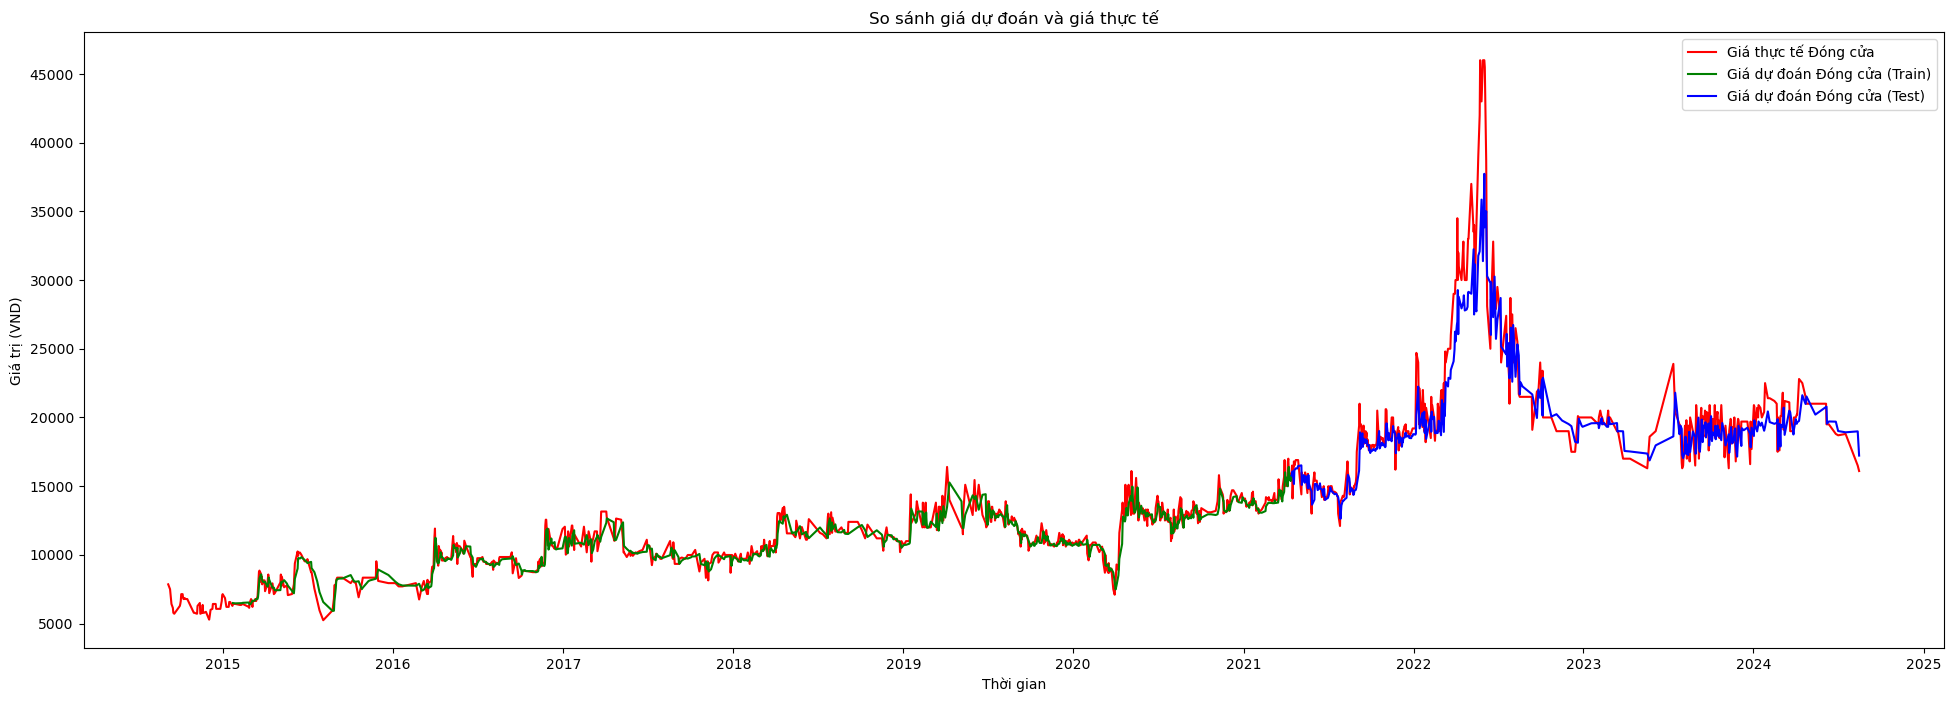

In [17]:
def bieudo3tap():
    plt.figure(figsize=(24,8))
    plt.plot(df1['Price'], label="Giá thực tế Đóng cửa", color='red')
    #plt.plot(df1['Open'], label="Giá thực tế Mở cửa", color='orange')
    #plt.plot(df1['High'], label="Giá thực tế Cao nhất", color='purple')
    #plt.plot(df1['Low'], label="Giá thực tế Thấp nhất", color='brown')

    plt.plot(train_data_1['Dự đoán Đóng cửa'], label='Giá dự đoán Đóng cửa (Train)', color='green')
    plt.plot(test_data_1['Dự đoán Đóng cửa'], label='Giá dự đoán Đóng cửa (Test)', color='blue')

    plt.title("So sánh giá dự đoán và giá thực tế")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()
bieudo3tap()



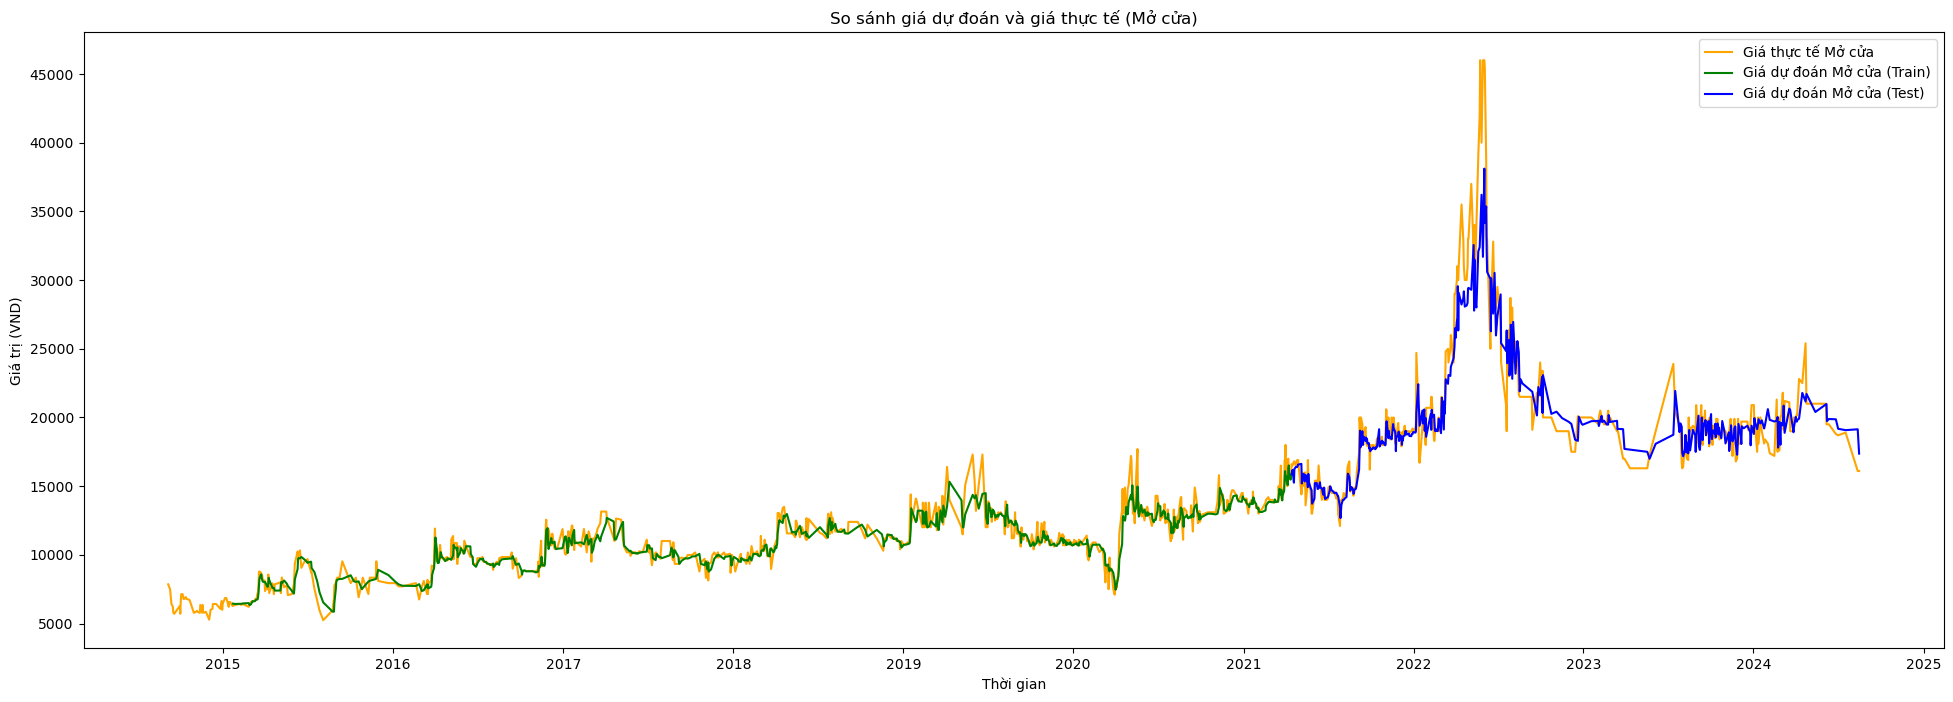

In [18]:

def bieudo_mo_cua():
    plt.figure(figsize=(24,8))
    plt.plot(df1['Open'], label="Giá thực tế Mở cửa", color='orange')
    plt.plot(train_data_1['Dự đoán Mở cửa'], label='Giá dự đoán Mở cửa (Train)', color='green')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong train data tìm ở bên trên
    plt.plot(test_data_1['Dự đoán Mở cửa'], label='Giá dự đoán Mở cửa (Test)', color='blue')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong test data tìm ở bên trên

    plt.title("So sánh giá dự đoán và giá thực tế (Mở cửa)")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()

bieudo_mo_cua()

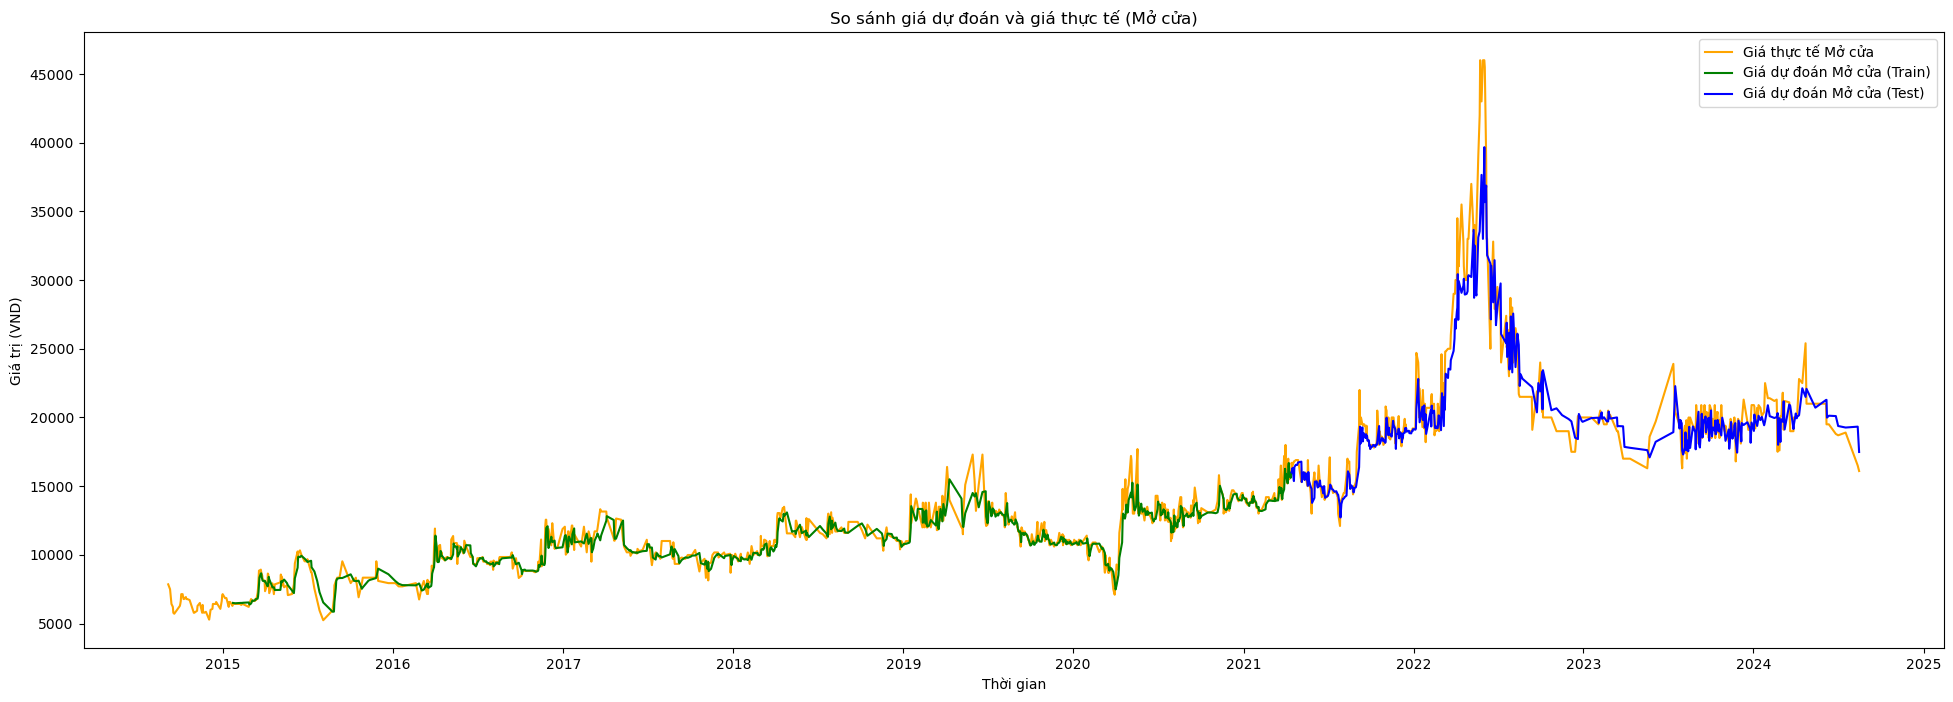

In [19]:

def bieudo_cao_nhat():
    plt.figure(figsize=(24,8))
    plt.plot(df1['High'], label="Giá thực tế Mở cửa", color='orange')
    plt.plot(train_data_1['Dự đoán Cao nhất'], label='Giá dự đoán Mở cửa (Train)', color='green')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong train data tìm ở bên trên
    plt.plot(test_data_1['Dự đoán Cao nhất'], label='Giá dự đoán Mở cửa (Test)', color='blue')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong test data tìm ở bên trên

    plt.title("So sánh giá dự đoán và giá thực tế (Mở cửa)")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()

bieudo_cao_nhat()

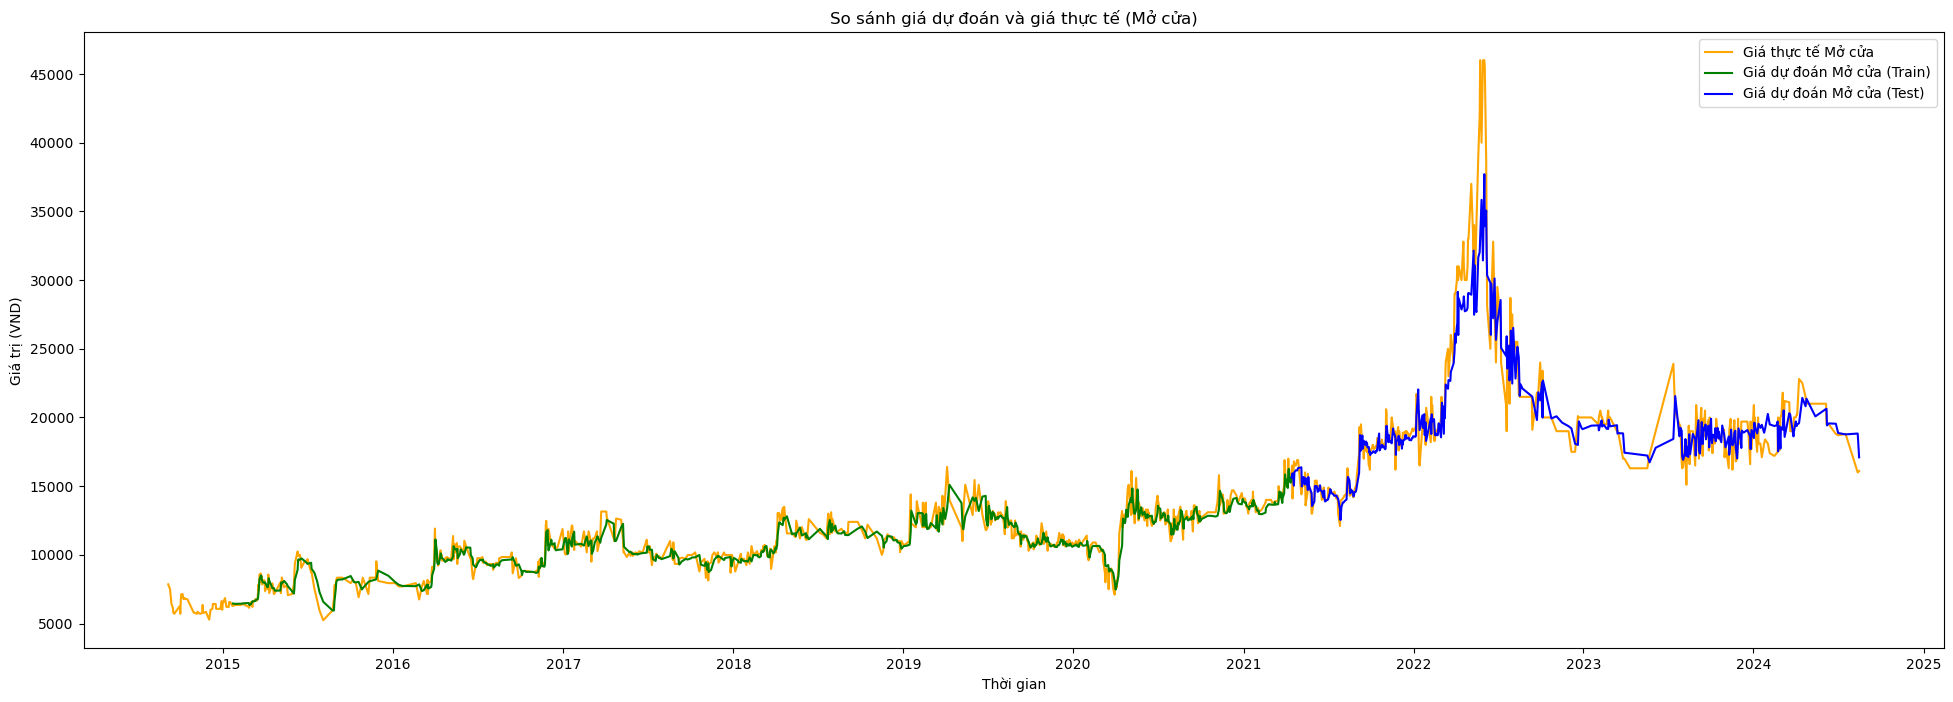

In [20]:

def bieudo_thap_nhat():
    plt.figure(figsize=(24,8))
    plt.plot(df1['Low'], label="Giá thực tế Mở cửa", color='orange')
    plt.plot(train_data_1['Dự đoán Thấp nhất'], label='Giá dự đoán Mở cửa (Train)', color='green')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong train data tìm ở bên trên
    plt.plot(test_data_1['Dự đoán Thấp nhất'], label='Giá dự đoán Mở cửa (Test)', color='blue')#Dự đoán mở cửa là tên ta đặt cho column đầu tiên trong test data tìm ở bên trên

    plt.title("So sánh giá dự đoán và giá thực tế (Mở cửa)")
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị (VND)')
    plt.legend()
    plt.show()

bieudo_thap_nhat()

In [21]:
train_data_1 = pd.DataFrame({
    'Price Đóng cửa': y_train[:, 0].flatten(),  # Giá thực tế Đóng cửa
    'Dự đoán Đóng cửa': y_train_predict[:, 0].flatten(),  # Giá dự đoán Đóng cửa
    'Price Mở cửa': y_train[:, 1].flatten(),  # Giá thực tế Mở cửa
    'Dự đoán Mở cửa': y_train_predict[:, 1].flatten(),  # Giá dự đoán Mở cửa
    'Price Cao nhất': y_train[:, 2].flatten(),  # Giá thực tế Cao nhất
    'Dự đoán Cao nhất': y_train_predict[:, 2].flatten(),  # Giá dự đoán Cao nhất
    'Price Thấp nhất': y_train[:, 3].flatten(),  # Giá thực tế Thấp nhất
    'Dự đoán Thấp nhất': y_train_predict[:, 3].flatten(),  # Giá dự đoán Thấp nhất
}, index=df1.index[50:a])  # Sử dụng index của dữ liệu gốc để tạo cột Date

# Hiển thị bảng so sánh cho tập huấn luyện
print(train_data_1.head())


            Price Đóng cửa  Dự đoán Đóng cửa  Price Mở cửa  Dự đoán Mở cửa  \
Date                                                                         
2015-01-22          6426.0       6491.918457        6283.0     6449.591309   
2015-01-27          6426.0       6469.660156        6355.0     6426.320312   
2015-02-06          6355.0       6486.046387        6426.0     6441.401367   
2015-02-09          6355.0       6498.921875        6355.0     6453.785156   
2015-02-11          6426.0       6486.611816        6426.0     6441.525879   

            Price Cao nhất  Dự đoán Cao nhất  Price Thấp nhất  \
Date                                                            
2015-01-22          6426.0       6501.609863           6283.0   
2015-01-27          6426.0       6477.013184           6355.0   
2015-02-06          6426.0       6492.160645           6355.0   
2015-02-09          6355.0       6504.245117           6355.0   
2015-02-11          6426.0       6490.655762           6426.0  

In [22]:
test_data_1 = pd.DataFrame({
    'Price Đóng cửa': y_test[:, 0].flatten(),  # Giá thực tế Đóng cửa
    'Dự đoán Đóng cửa': y_test_predict[:, 0].flatten(),  # Giá dự đoán Đóng cửa
    'Price Mở cửa': y_test[:, 1].flatten(),  # Giá thực tế Mở cửa
    'Dự đoán Mở cửa': y_test_predict[:, 1].flatten(),  # Giá dự đoán Mở cửa
    'Price Cao nhất': y_test[:, 2].flatten(),  # Giá thực tế Cao nhất
    'Dự đoán Cao nhất': y_test_predict[:, 2].flatten(),  # Giá dự đoán Cao nhất
    'Price Thấp nhất': y_test[:, 3].flatten(),  # Giá thực tế Thấp nhất
    'Dự đoán Thấp nhất': y_test_predict[:, 3].flatten(),  # Giá dự đoán Thấp nhất
}, index=df1.index[a:])  # Sử dụng index của dữ liệu gốc để tạo cột Date

# Hiển thị bảng so sánh cho tập kiểm tra
print(test_data_1.head())


            Price Đóng cửa  Dự đoán Đóng cửa  Price Mở cửa  Dự đoán Mở cửa  \
Date                                                                         
2021-04-14           16000      15767.853516         16600    15864.872070   
2021-04-15           16500      15921.011719         16500    16017.344727   
2021-04-16           14100      16074.676758         16500    16171.925781   
2021-04-19           16800      15156.749023         16800    15255.150391   
2021-04-20           16500      16152.591797         16800    16245.697266   

            Price Cao nhất  Dự đoán Cao nhất  Price Thấp nhất  \
Date                                                            
2021-04-14           16700      16000.207031            16000   
2021-04-15           16500      16158.596680            16500   
2021-04-16           16500      16319.041016            14100   
2021-04-19           16800      15369.807617            16800   
2021-04-20           16800      16393.953125            16500  

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def evaluate_predictions(y_true, y_pred, name=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"Đánh giá độ chính xác cho {name}:")
    print(f"R^2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print()
#Phù hợp tập test
print("Độ phù hợp tập test: ", 'R^2')
print("Sai số tuyệt đối trung bình tập test: ", 'MAE')
print("Phần trăm sai số tuyệt đối trung bình tập test: ", 'MAPE\n')

#Price Đóng cửa vừa tạo bên trên lấy data từ Price cũ
# Đánh giá trên tập huấn luyện
evaluate_predictions(train_data_1['Price Đóng cửa'], train_data_1['Dự đoán Đóng cửa'], "Đóng cửa (Train)")
evaluate_predictions(train_data_1['Price Mở cửa'], train_data_1['Dự đoán Mở cửa'], "Mở cửa (Train)")
evaluate_predictions(train_data_1['Price Cao nhất'], train_data_1['Dự đoán Cao nhất'], "Cao nhất (Train)")
evaluate_predictions(train_data_1['Price Thấp nhất'], train_data_1['Dự đoán Thấp nhất'], "Thấp nhất (Train)")

# Đánh giá trên tập kiểm tra
evaluate_predictions(test_data_1['Price Đóng cửa'], test_data_1['Dự đoán Đóng cửa'], "Đóng cửa (Test)")
evaluate_predictions(test_data_1['Price Mở cửa'], test_data_1['Dự đoán Mở cửa'], "Mở cửa (Test)")
evaluate_predictions(test_data_1['Price Cao nhất'], test_data_1['Dự đoán Cao nhất'], "Cao nhất (Test)")
evaluate_predictions(test_data_1['Price Thấp nhất'], test_data_1['Dự đoán Thấp nhất'], "Thấp nhất (Test)")


Độ phù hợp tập test:  R^2
Sai số tuyệt đối trung bình tập test:  MAE
Phần trăm sai số tuyệt đối trung bình tập test:  MAPE

Đánh giá độ chính xác cho Đóng cửa (Train):
R^2: 0.8895
MAE: 487.8343
MAPE: 0.0438%

Đánh giá độ chính xác cho Mở cửa (Train):
R^2: 0.8809
MAE: 511.4139
MAPE: 0.0455%

Đánh giá độ chính xác cho Cao nhất (Train):
R^2: 0.8812
MAE: 514.7650
MAPE: 0.0452%

Đánh giá độ chính xác cho Thấp nhất (Train):
R^2: 0.8913
MAE: 483.3465
MAPE: 0.0441%

Đánh giá độ chính xác cho Đóng cửa (Test):
R^2: 0.8247
MAE: 1387.0839
MAPE: 0.0604%

Đánh giá độ chính xác cho Mở cửa (Test):
R^2: 0.8470
MAE: 1207.0304
MAPE: 0.0528%

Đánh giá độ chính xác cho Cao nhất (Test):
R^2: 0.8588
MAE: 1259.3268
MAPE: 0.0549%

Đánh giá độ chính xác cho Thấp nhất (Test):
R^2: 0.8419
MAE: 1251.2975
MAPE: 0.0560%



In [24]:
# Lưu bảng so sánh của tập huấn luyện ra tệp CSV
train_data_1.to_csv('train_data_comparison.csv')

# Lưu bảng so sánh của tập kiểm tra ra tệp CSV
test_data_1.to_csv('test_data_comparison.csv')

train_data_1.to_csv('file_test.csv')



In [25]:
test_data_1.to_csv('file_test.csv')
